In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [21]:
df=pd.read_csv('train.csv_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [22]:
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

{'toxic': np.int64(15294), 'severe_toxic': np.int64(1595), 'obscene': np.int64(8449), 'threat': np.int64(478), 'insult': np.int64(7877), 'identity_hate': np.int64(1405)}


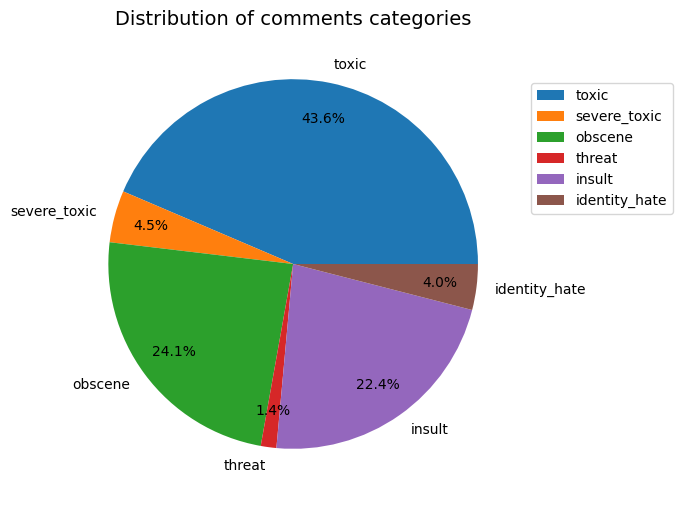

In [23]:
temp = {}
for x in df.columns[2:]:
    temp[x] = df[x].sum()

print(temp)

plt.figure(figsize=(7, 6))
plt.pie(temp.values(), 
        labels=temp.keys(), 
        autopct='%1.1f%%', 
        pctdistance=0.80
       )
plt.title('Distribution of comments categories', size=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0, 1, 1.5))



In [24]:
import re
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df['comment_text'] = df['comment_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

/tmp/ipykernel_29562/1002394905.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)


In [25]:
df[df['toxic'] == 1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,cocksucker before you piss around on my work,1,1,1,0,1,0
12,0005c987bdfc9d4b,hey what is it\n talk \nwhat is it an exclusi...,1,0,0,0,0,0
16,0007e25b2121310b,bye \n\ndont look come or think of comming bac...,1,0,0,0,0,0
42,001810bf8c45bf5f,you are gay or antisemmitian \n\narchangel whi...,1,0,1,0,1,1
43,00190820581d90ce,fuck your filthy mother in the ass dry,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,\n\n our previous conversation \n\nyou fucking...,1,0,1,0,1,1
159514,ff39a2895fc3b40e,you are a mischievious pubic hair,1,0,0,0,1,0
159541,ffa33d3122b599d6,your absurd edits \n\nyour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,\n\nhey listen dont you ever delete my edits e...,1,0,0,0,1,0


In [26]:
df_toxic_labels = df.columns[2:]
df['num_of_labels'] = df[df_toxic_labels].sum(axis=1)
print("Number of comments with multiple labels: ", (df['num_of_labels']>1).sum())

Number of comments with multiple labels:  9865


In [27]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,num_of_labels
0,0000997932d777bf,explanation\nwhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he matches this background colour im seem...,0,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not trying to edit war its j...,0,0,0,0,0,0,0
3,0001b41b1c6bb37e,\nmore\ni cant make any real suggestions on im...,0,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0,0


In [28]:
toxic_labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
def build_conditional_prob_matrix(df, labels):
    cooc = df[labels].values.T.dot(df[labels].values)
    cooc_norm = cooc.copy().astype(np.float32)
    for i in range(cooc_norm.shape[0]):
        cooc_norm[:, i] /= cooc[i, i]
    return cooc_norm

cooc_norm = build_conditional_prob_matrix(df, toxic_labels)
def sample_probabilistic(df, labels, target_count, cond_prob):
    target_counts = np.array([target_count for _ in labels])
    prob_distribution = np.dot(cond_prob, target_counts)
    prob_distribution /= prob_distribution.sum()
    
    df_subs = []
    for i, label in enumerate(labels):
        sub_df = df[df[label] == 1]
        # Sample according to the computed probabilities
        sample_size = int(len(sub_df) * prob_distribution[i])
        df_subs.append(sub_df.sample(sample_size, replace=True))
    
    sampled_df = pd.concat(df_subs)
    return sampled_df

df_toxic = sample_probabilistic(df, toxic_labels, 500, cooc_norm)

In [29]:
counts = df['num_of_labels'].value_counts()
counts

num_of_labels
0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: count, dtype: int64

In [30]:
for x in df.columns[2:8]:
    temp[x] = df[x].sum()
    print(temp[x])
print(len(df))

15294
1595
8449
478
7877
1405
159571


In [31]:
df["toxic_sum"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1)
non_toxic_rows = df[df["toxic_sum"] == 0]
non_toxic_rows.shape

(143346, 10)

In [32]:
df["toxic_sum"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1)
non_toxic_rows = df[df["toxic_sum"] == 0]
counts = df_toxic['num_of_labels'].value_counts()
second_max = counts.iloc[0]
max_toxic_count = second_max*1.5
downsampled_non_toxic = non_toxic_rows.sample(n=int(max_toxic_count), random_state=42)
df = pd.concat([df_toxic, downsampled_non_toxic], ignore_index=True)
df.drop(columns=["toxic_sum"], inplace=True)

In [33]:
df['num_of_labels'].value_counts()

num_of_labels
0    4516
3    3011
1    1830
2    1767
4    1517
5     351
6      35
Name: count, dtype: int64

In [34]:
for x in df.columns[2:8]:
    temp[x] = df[x].sum()
    print(temp[x])
print(len(df))

8241
1323
5885
347
5591
1043
13027


Number of comments with multiple labels:  6681


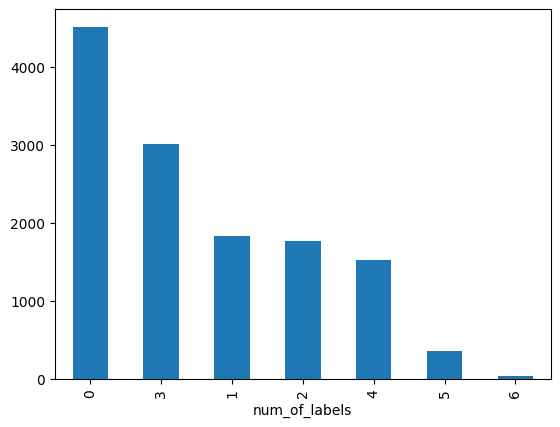

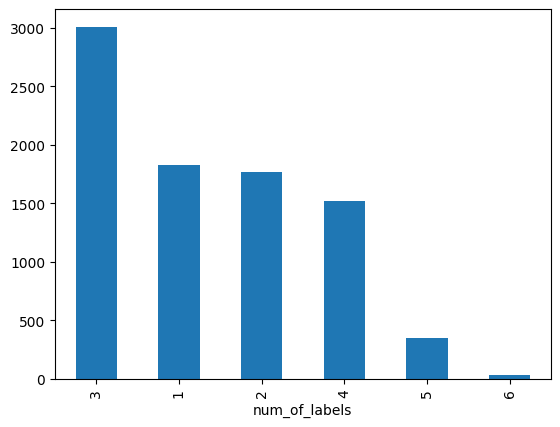

In [35]:
plt.figure()
print("Number of comments with multiple labels: ", (df['num_of_labels']>1).sum())
df['num_of_labels'].value_counts().plot(kind='bar')
plt.show()

plt.figure()
df[df['num_of_labels']>0]['num_of_labels'].value_counts().plot(kind='bar')
plt.show()

{'toxic': np.int64(8241), 'severe_toxic': np.int64(1323), 'obscene': np.int64(5885), 'threat': np.int64(347), 'insult': np.int64(5591), 'identity_hate': np.int64(1043)}


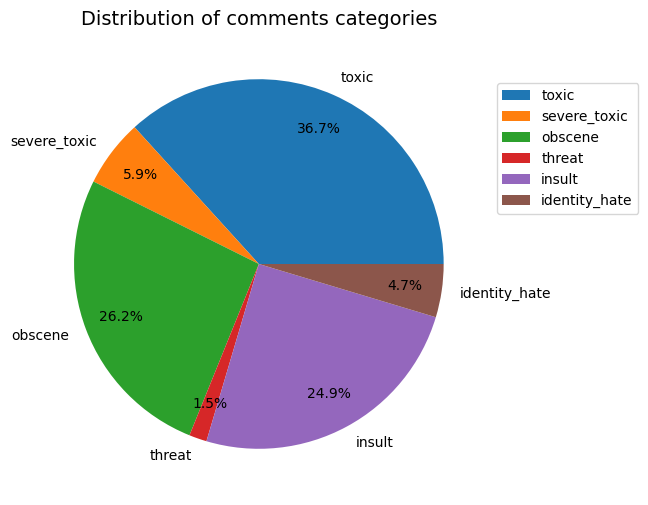

In [36]:
temp = {}
for x in df.columns[2:8]:
    temp[x] = df[x].sum()

print(temp)
plt.figure(figsize=(7, 6))
plt.pie(temp.values(), 
        labels=temp.keys(), 
        autopct='%1.1f%%', 
        pctdistance=0.80
       )
plt.title('Distribution of comments categories', size=14)
plt.legend(loc='center left', bbox_to_anchor=(1, 0, 1, 1.5))



In [37]:
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X = [
    tokenizer(text, add_special_tokens=False, truncation=True)["input_ids"]
    for text in df['comment_text'].values
]

y = df.values[:, 2:8].astype(np.float32)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test
print(f'X_train sample: {len(X_train), len(X_test)}')  # Example output to inspect
print(f'y_train shape: {y_train.shape, y_test.shape}')  # Example to inspect the shape of y_train


X_train sample: (9118, 1955)
y_train shape: ((9118, 6), (1955, 6))


In [38]:
sample_index = 105  
decoded_text = tokenizer.decode(X[sample_index], skip_special_tokens=True)
print(f"Decoded text (sample {sample_index}): {decoded_text}")
print(df['comment_text'].iloc[sample_index])

Decoded text (sample 105): moron i think you are a snivelling moron unworthy to be a member of an encyclopedia project
moron

i think you are a snivelling moron unworthy to be a member of an encyclopedia project


In [39]:
import numpy as np
from statistics import mode

sequence_lengths = [len(seq) for seq in X]
average_length = np.mean(sequence_lengths)
median_length = np.median(sequence_lengths)
try:
    mode_length = mode(sequence_lengths)
except:
    mode_length = "No unique mode" 

# Print the results
print(f"Average length of sequences: {average_length:.2f}")
print(f"Median length of sequences: {median_length}")
print(f"Mode length of sequences: {mode_length}")

Average length of sequences: 59.81
Median length of sequences: 29.0
Mode length of sequences: 7


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = [torch.tensor(x, dtype=torch.long) for x in X]
        self.y = [torch.tensor(y_t, dtype=torch.float32) for y_t in y]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts, labels = zip(*[(text, label) for text, label in zip(texts, labels) if len(text) > 0])
    padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
    text_lengths = torch.tensor([len(text) for text in texts]) 
    labels = torch.stack(labels)
    
    return padded_texts, text_lengths, labels

In [41]:
train_dataset = TextDataset(X_train, y_train)
test_dataset=TextDataset(X_test, y_test)
val_dataset = TextDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [42]:
next(iter(train_loader))

/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


(tensor([[ 1045,  3246,  2008,  ...,     0,     0,     0],
         [ 8945,  7174, 10603,  ...,     0,     0,     0],
         [ 7928,  2107,  2004,  ...,     0,     0,     0],
         ...,
         [ 1045,  3984,  2061,  ...,     0,     0,     0],
         [ 3383,  2017,  2024,  ...,     0,     0,     0],
         [ 1045,  2123,  2102,  ...,     0,     0,     0]]),
 tensor([ 41,  21,  52,  15,  27,   8,  50,   9, 165,  78,  26,  74,  48,  11,
          12,  44]),
 tensor([[0., 0., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0.],
         [1., 0., 1., 0., 1., 0.],
         [1., 0., 1., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0.],
         [1., 0., 0., 0., 1., 1.],
         [1., 0., 1., 0., 1., 0.],
         [1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [1., 1., 0., 0., 0., 0.],
         [1., 0., 1., 0., 1., 0.],
         [1., 0., 0., 0., 1., 0.],
         [1., 1., 1., 0., 1., 0.],
         [1., 0., 0., 0., 1., 0.],
     

In [43]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim, num_heads=1):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, 128) 
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, output_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, _ = self.rnn(packed_embedded)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        x = output[:, -1, :]
        x = torch.relu(self.fc1(x)) 
        x = torch.relu(self.fc2(x))  
        return self.fc3(x)

In [44]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score,f1_score
import numpy as np

output_dim=6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim=tokenizer.vocab_size


def objective(trial):
    # Define hyperparameters to search over
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 140, step=16)
    hidden_dim = trial.suggest_int('hidden_dim', 128, 768, step=128)
    embedding_dim = trial.suggest_int('embedding_dim', 128, 768, step=64)
    class_weights = [trial.suggest_float(f'class_weight_{i}', 0.1, 12, log=True) for i in range(output_dim)]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
    model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    num_epochs = 3  
    best_val_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            texts, text_lengths, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts, text_lengths)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        model.eval()
        val_loss = 0.0
        val_true = []
        val_pred = []
        with torch.no_grad():
            for val_batch in val_loader:
                val_texts, val_text_lengths, val_labels = val_batch
                val_texts, val_labels = val_texts.to(device), val_labels.to(device)
                val_outputs = model(val_texts, val_text_lengths)
                val_loss += loss_fn(val_outputs, val_labels).item()
                val_preds = torch.sigmoid(val_outputs) > 0.5

                val_true.append(val_labels.cpu().numpy())
                val_pred.append(val_preds.cpu().numpy())
        
        val_loss /= len(val_loader)
        running_loss/=len(train_loader)
        val_true = np.concatenate(val_true, axis=0)
        val_pred = np.concatenate(val_pred, axis=0)

        val_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f'Epoch {epoch+1}/{num_epochs}, Validation F1 Score: {val_f1:.4f}, Val Loss: {val_loss:.4f} Train Loss: {running_loss:.4f}')
        # Save the model if the validation F1 improves
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1


    del model
    del optimizer, train_loader, val_loader, class_weights_tensor
    torch.cuda.empty_cache() 
    return best_val_f1


study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=30)  


print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)


[I 2024-12-03 15:33:23,537] A new study created in memory with name: no-name-57b8a6ed-e3af-4656-877e-d901a2fb18c0
/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6062, Val Loss: 0.6704 Train Loss: 0.7326


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6050, Val Loss: 0.6711 Train Loss: 0.6758


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:33:57,393] Trial 0 finished with value: 0.6062249494842493 and parameters: {'learning_rate': 0.007230832197069462, 'batch_size': 120, 'hidden_dim': 384, 'embedding_dim': 384, 'class_weight_0': 1.0014617136181272, 'class_weight_1': 0.22487982009657448, 'class_weight_2': 4.68414003373273, 'class_weight_3': 0.7991075684963396, 'class_weight_4': 5.532674107598723, 'class_weight_5': 1.4862746623672909}. Best is trial 0 with value: 0.6062249494842493.


Epoch 3/3, Validation F1 Score: 0.6062, Val Loss: 0.6694 Train Loss: 0.6745


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6067, Val Loss: 1.1338 Train Loss: 1.1337


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6061, Val Loss: 1.1304 Train Loss: 1.1286


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:34:28,227] Trial 1 finished with value: 0.6067131947495555 and parameters: {'learning_rate': 1.303659705208023e-05, 'batch_size': 136, 'hidden_dim': 384, 'embedding_dim': 128, 'class_weight_0': 6.673117386430447, 'class_weight_1': 1.3535332487892717, 'class_weight_2': 2.689733914432315, 'class_weight_3': 3.466816186773235, 'class_weight_4': 0.1751796819369948, 'class_weight_5': 0.4139852334246769}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.6062, Val Loss: 1.1270 Train Loss: 1.1271


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.1815, Val Loss: 0.6592 Train Loss: 0.6974


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.3195, Val Loss: 0.5012 Train Loss: 0.5846


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:34:47,440] Trial 2 finished with value: 0.3194851947753449 and parameters: {'learning_rate': 0.000141452063157592, 'batch_size': 56, 'hidden_dim': 128, 'embedding_dim': 768, 'class_weight_0': 0.18680874835885275, 'class_weight_1': 0.7703966526099197, 'class_weight_2': 2.063282738833859, 'class_weight_3': 2.624276256275975, 'class_weight_4': 1.298498625367591, 'class_weight_5': 0.14533646576764092}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.1783, Val Loss: 0.4374 Train Loss: 0.4650


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.1536, Val Loss: 0.6460 Train Loss: 0.6570


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.1538, Val Loss: 0.6021 Train Loss: 0.6260


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:35:21,425] Trial 3 finished with value: 0.15376298908393732 and parameters: {'learning_rate': 1.2633395867068935e-05, 'batch_size': 8, 'hidden_dim': 128, 'embedding_dim': 128, 'class_weight_0': 0.277021617373869, 'class_weight_1': 0.7417302938425918, 'class_weight_2': 1.0054711773367628, 'class_weight_3': 0.6127088402929555, 'class_weight_4': 1.6774761242087217, 'class_weight_5': 1.0050480259058292}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.1538, Val Loss: 0.5426 Train Loss: 0.5711


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.1756, Val Loss: 0.5976 Train Loss: 0.6353


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.1802, Val Loss: 0.5955 Train Loss: 0.6061


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:35:37,349] Trial 4 finished with value: 0.1889174685329143 and parameters: {'learning_rate': 0.009426287782902875, 'batch_size': 120, 'hidden_dim': 128, 'embedding_dim': 576, 'class_weight_0': 0.12586174693419944, 'class_weight_1': 10.02561749985395, 'class_weight_2': 4.3978045132490635, 'class_weight_3': 7.608975551748935, 'class_weight_4': 0.10114040032991027, 'class_weight_5': 0.233280825153176}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.1889, Val Loss: 0.6059 Train Loss: 0.6040


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4523, Val Loss: 0.5292 Train Loss: 0.5619


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4525, Val Loss: 0.5254 Train Loss: 0.5367


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:36:31,768] Trial 5 finished with value: 0.45246196040031206 and parameters: {'learning_rate': 0.00398438535098959, 'batch_size': 8, 'hidden_dim': 384, 'embedding_dim': 448, 'class_weight_0': 11.978537126084088, 'class_weight_1': 0.15328442713541487, 'class_weight_2': 1.5386515017238631, 'class_weight_3': 4.41607957863593, 'class_weight_4': 0.26068251478966187, 'class_weight_5': 0.16945969589842969}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.4525, Val Loss: 0.5221 Train Loss: 0.5346


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.0017, Val Loss: 0.5620 Train Loss: 0.5659


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.0017, Val Loss: 0.5573 Train Loss: 0.5611


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:36:49,445] Trial 6 finished with value: 0.0016669519512723268 and parameters: {'learning_rate': 1.8518437736996378e-05, 'batch_size': 72, 'hidden_dim': 128, 'embedding_dim': 704, 'class_weight_0': 0.39894283863906327, 'class_weight_1': 0.13140763757826093, 'class_weight_2': 0.8108785359691293, 'class_weight_3': 0.2947931424433111, 'class_weight_4': 0.14541909574894807, 'class_weight_5': 0.4315469874235385}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.0017, Val Loss: 0.5519 Train Loss: 0.5561


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6050, Val Loss: 0.7939 Train Loss: 0.7933


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6058, Val Loss: 0.7909 Train Loss: 0.7903


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:37:10,215] Trial 7 finished with value: 0.6062106221410313 and parameters: {'learning_rate': 1.0569353777746393e-05, 'batch_size': 72, 'hidden_dim': 256, 'embedding_dim': 384, 'class_weight_0': 3.0555762309460945, 'class_weight_1': 0.4602532049669816, 'class_weight_2': 0.4100702602117461, 'class_weight_3': 0.5788594674102904, 'class_weight_4': 1.044375105052523, 'class_weight_5': 1.5877733340862403}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.6062, Val Loss: 0.7877 Train Loss: 0.7872


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6062, Val Loss: 0.6854 Train Loss: 0.9544


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6057, Val Loss: 0.6052 Train Loss: 0.6221


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:38:05,141] Trial 8 finished with value: 0.6062249494842493 and parameters: {'learning_rate': 0.00045167984379251744, 'batch_size': 72, 'hidden_dim': 768, 'embedding_dim': 640, 'class_weight_0': 5.336156604834712, 'class_weight_1': 0.3613341138185574, 'class_weight_2': 2.070420353811384, 'class_weight_3': 0.10563169272968113, 'class_weight_4': 2.7361387377119777, 'class_weight_5': 0.43657097412502927}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.6056, Val Loss: 0.6069 Train Loss: 0.5994


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.1658, Val Loss: 0.4276 Train Loss: 0.4791


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.1655, Val Loss: 0.4318 Train Loss: 0.4435


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:39:03,253] Trial 9 finished with value: 0.1660203422011673 and parameters: {'learning_rate': 0.00036471527143113765, 'batch_size': 8, 'hidden_dim': 512, 'embedding_dim': 512, 'class_weight_0': 0.18846770361159615, 'class_weight_1': 0.5130034060873019, 'class_weight_2': 2.662823007426803, 'class_weight_3': 6.57101333240449, 'class_weight_4': 0.605492577534026, 'class_weight_5': 0.21386587506730742}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.1660, Val Loss: 0.4271 Train Loss: 0.4409


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.3180, Val Loss: 1.3854 Train Loss: 1.3757


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4767, Val Loss: 1.3582 Train Loss: 1.3591


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:39:49,047] Trial 10 finished with value: 0.4767799723909281 and parameters: {'learning_rate': 6.182389556265526e-05, 'batch_size': 136, 'hidden_dim': 640, 'embedding_dim': 128, 'class_weight_0': 1.9023021429235005, 'class_weight_1': 2.7356384722697387, 'class_weight_2': 11.875493039169273, 'class_weight_3': 2.201748544262692, 'class_weight_4': 0.3627131209468347, 'class_weight_5': 6.659903347498927}. Best is trial 1 with value: 0.6067131947495555.


Epoch 3/3, Validation F1 Score: 0.4768, Val Loss: 1.3391 Train Loss: 1.3461


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6127, Val Loss: 0.8481 Train Loss: 1.0873


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6093, Val Loss: 0.8452 Train Loss: 0.8561


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:40:16,032] Trial 11 finished with value: 0.6126519523769323 and parameters: {'learning_rate': 0.0013669049394735395, 'batch_size': 104, 'hidden_dim': 384, 'embedding_dim': 320, 'class_weight_0': 0.7769858026615923, 'class_weight_1': 2.018096437807555, 'class_weight_2': 6.90391413776495, 'class_weight_3': 1.632366360003261, 'class_weight_4': 10.259908755033972, 'class_weight_5': 2.3180794078375606}. Best is trial 11 with value: 0.6126519523769323.


Epoch 3/3, Validation F1 Score: 0.6124, Val Loss: 0.8418 Train Loss: 0.8535


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4485, Val Loss: 0.6480 Train Loss: 0.7578


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4480, Val Loss: 0.6491 Train Loss: 0.6620


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:40:49,322] Trial 12 finished with value: 0.44848611461729104 and parameters: {'learning_rate': 0.001474658500275439, 'batch_size': 104, 'hidden_dim': 512, 'embedding_dim': 256, 'class_weight_0': 0.712606730038736, 'class_weight_1': 2.5387114306074543, 'class_weight_2': 0.11514775131343631, 'class_weight_3': 1.7134181657801792, 'class_weight_4': 7.765759577931503, 'class_weight_5': 4.410576563065459}. Best is trial 11 with value: 0.6126519523769323.


Epoch 3/3, Validation F1 Score: 0.4477, Val Loss: 0.6441 Train Loss: 0.6534


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6140, Val Loss: 1.1448 Train Loss: 1.5747


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6119, Val Loss: 1.1413 Train Loss: 1.1678


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:41:15,398] Trial 13 finished with value: 0.6139549787144429 and parameters: {'learning_rate': 0.0016860000267250575, 'batch_size': 104, 'hidden_dim': 384, 'embedding_dim': 256, 'class_weight_0': 10.110339496587054, 'class_weight_1': 2.4170192820592784, 'class_weight_2': 10.42004641833151, 'class_weight_3': 11.912178426243255, 'class_weight_4': 11.765404632522133, 'class_weight_5': 3.154697475407593}. Best is trial 13 with value: 0.6139549787144429.


Epoch 3/3, Validation F1 Score: 0.6120, Val Loss: 1.1413 Train Loss: 1.1650


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6147, Val Loss: 1.0160 Train Loss: 1.3933


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6117, Val Loss: 1.0157 Train Loss: 1.0171


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:41:34,540] Trial 14 finished with value: 0.6157455149992699 and parameters: {'learning_rate': 0.0013959488679915594, 'batch_size': 104, 'hidden_dim': 256, 'embedding_dim': 256, 'class_weight_0': 1.804822661648553, 'class_weight_1': 5.4749585810349615, 'class_weight_2': 11.941424307753516, 'class_weight_3': 0.2606136586691383, 'class_weight_4': 11.61203045892696, 'class_weight_5': 3.1223964312547987}. Best is trial 14 with value: 0.6157455149992699.


Epoch 3/3, Validation F1 Score: 0.6157, Val Loss: 1.0114 Train Loss: 1.0128


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6143, Val Loss: 0.9497 Train Loss: 1.1124


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6140, Val Loss: 0.9478 Train Loss: 0.9520


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:41:53,042] Trial 15 finished with value: 0.614302994657577 and parameters: {'learning_rate': 0.0015787006699804764, 'batch_size': 88, 'hidden_dim': 256, 'embedding_dim': 256, 'class_weight_0': 2.1768971572461, 'class_weight_1': 5.608389987402695, 'class_weight_2': 11.20910881981531, 'class_weight_3': 0.21005776724441808, 'class_weight_4': 4.380510725975669, 'class_weight_5': 3.875374447035786}. Best is trial 14 with value: 0.6157455149992699.


Epoch 3/3, Validation F1 Score: 0.6143, Val Loss: 0.9500 Train Loss: 0.9473


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6168, Val Loss: 1.0068 Train Loss: 1.1141


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6171, Val Loss: 1.0056 Train Loss: 1.0100


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:42:10,185] Trial 16 finished with value: 0.6189402204171007 and parameters: {'learning_rate': 0.0007096361227376998, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 256, 'class_weight_0': 2.003622307132544, 'class_weight_1': 8.17005763189202, 'class_weight_2': 6.794064760896427, 'class_weight_3': 0.1745394742393066, 'class_weight_4': 4.678264723929618, 'class_weight_5': 8.758962355623428}. Best is trial 16 with value: 0.6189402204171007.


Epoch 3/3, Validation F1 Score: 0.6189, Val Loss: 1.0123 Train Loss: 1.0033


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6182, Val Loss: 1.0052 Train Loss: 1.1044


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6240, Val Loss: 0.9988 Train Loss: 0.9991


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:42:26,719] Trial 17 finished with value: 0.6240191163658537 and parameters: {'learning_rate': 0.0005492892514939486, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 1.773796522498064, 'class_weight_1': 10.972286617091951, 'class_weight_2': 4.667513607386336, 'class_weight_3': 0.10805032260723799, 'class_weight_4': 3.2623457048055413, 'class_weight_5': 11.630330627906481}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6177, Val Loss: 1.0048 Train Loss: 0.9965


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6180, Val Loss: 1.3045 Train Loss: 1.3853


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6177, Val Loss: 1.0892 Train Loss: 1.1815


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:42:43,151] Trial 18 finished with value: 0.6179929965853129 and parameters: {'learning_rate': 0.0001230804421176717, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 4.313955882782585, 'class_weight_1': 11.229166817781211, 'class_weight_2': 5.334384374070919, 'class_weight_3': 0.1703469401461026, 'class_weight_4': 2.783251344800859, 'class_weight_5': 10.988663052763536}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6178, Val Loss: 1.0543 Train Loss: 1.0713


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4484, Val Loss: 0.7230 Train Loss: 0.7879


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4600, Val Loss: 0.7200 Train Loss: 0.7196


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:43:01,999] Trial 19 finished with value: 0.4600076004778796 and parameters: {'learning_rate': 0.0006409289544711092, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 384, 'class_weight_0': 1.3359781227780176, 'class_weight_1': 5.12761182101714, 'class_weight_2': 0.2948042254829967, 'class_weight_3': 0.10966175638052343, 'class_weight_4': 2.7939625116194606, 'class_weight_5': 10.404019305866827}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.4539, Val Loss: 0.7263 Train Loss: 0.7136


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.3280, Val Loss: 1.0301 Train Loss: 1.0874


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.3375, Val Loss: 0.9047 Train Loss: 0.9522


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:43:27,773] Trial 20 finished with value: 0.3434157847766393 and parameters: {'learning_rate': 0.00015545268843266744, 'batch_size': 40, 'hidden_dim': 512, 'embedding_dim': 192, 'class_weight_0': 0.4821249593111657, 'class_weight_1': 7.4133678387714, 'class_weight_2': 4.029795525842796, 'class_weight_3': 0.3825428582242152, 'class_weight_4': 4.545462040642628, 'class_weight_5': 7.829180673959711}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.3434, Val Loss: 0.8831 Train Loss: 0.8909


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6161, Val Loss: 1.1977 Train Loss: 1.3300


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6161, Val Loss: 1.0022 Train Loss: 1.0682


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:43:44,079] Trial 21 finished with value: 0.6161104133193948 and parameters: {'learning_rate': 0.00015524875155823294, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 3.9412475723541736, 'class_weight_1': 10.658579745194599, 'class_weight_2': 6.15642233892916, 'class_weight_3': 0.17669321616333655, 'class_weight_4': 2.509461578941656, 'class_weight_5': 6.191080905518998}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6161, Val Loss: 0.9873 Train Loss: 0.9946


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4623, Val Loss: 1.3454 Train Loss: 1.3756


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6159, Val Loss: 1.2186 Train Loss: 1.2821


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:44:03,032] Trial 22 finished with value: 0.6160735100479616 and parameters: {'learning_rate': 4.671572309174756e-05, 'batch_size': 24, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 3.280865173610483, 'class_weight_1': 11.459760706899205, 'class_weight_2': 6.576449485653359, 'class_weight_3': 0.16683215742735036, 'class_weight_4': 1.93594763009754, 'class_weight_5': 10.861167204575098}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6161, Val Loss: 1.0920 Train Loss: 1.1488


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4596, Val Loss: 0.8586 Train Loss: 1.0124


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4745, Val Loss: 0.8500 Train Loss: 0.8563


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:44:16,100] Trial 23 finished with value: 0.47523819811327195 and parameters: {'learning_rate': 0.0006914176705990452, 'batch_size': 56, 'hidden_dim': 128, 'embedding_dim': 320, 'class_weight_0': 5.916845283424259, 'class_weight_1': 3.9334122965098604, 'class_weight_2': 3.6462738470300144, 'class_weight_3': 0.1303977589390574, 'class_weight_4': 0.8473375737520434, 'class_weight_5': 10.765951143871895}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.4752, Val Loss: 0.8496 Train Loss: 0.8492


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6128, Val Loss: 0.9834 Train Loss: 1.1722


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6139, Val Loss: 0.9665 Train Loss: 0.9763


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:44:36,311] Trial 24 finished with value: 0.6185179559133962 and parameters: {'learning_rate': 0.00022206423919034034, 'batch_size': 24, 'hidden_dim': 256, 'embedding_dim': 320, 'class_weight_0': 1.299559245642099, 'class_weight_1': 7.469622712072793, 'class_weight_2': 6.970898560054311, 'class_weight_3': 0.32529412936769614, 'class_weight_4': 6.149188997447552, 'class_weight_5': 6.010025022848457}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6185, Val Loss: 0.9635 Train Loss: 0.9645


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6116, Val Loss: 0.9895 Train Loss: 1.1849


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6153, Val Loss: 0.9779 Train Loss: 0.9854


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:44:56,752] Trial 25 finished with value: 0.6182032499222733 and parameters: {'learning_rate': 0.00025497904310235286, 'batch_size': 24, 'hidden_dim': 256, 'embedding_dim': 320, 'class_weight_0': 1.319817829100846, 'class_weight_1': 6.955446270361433, 'class_weight_2': 8.524809634483185, 'class_weight_3': 0.3722687404511053, 'class_weight_4': 6.939634998408724, 'class_weight_5': 5.337482311112478}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6182, Val Loss: 0.9734 Train Loss: 0.9774


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4458, Val Loss: 0.7637 Train Loss: 0.8158


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4573, Val Loss: 0.7613 Train Loss: 0.7614


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:45:23,018] Trial 26 finished with value: 0.4573262438190098 and parameters: {'learning_rate': 0.0007568132454360396, 'batch_size': 24, 'hidden_dim': 384, 'embedding_dim': 448, 'class_weight_0': 2.378877518274474, 'class_weight_1': 3.404128497822528, 'class_weight_2': 0.61738564516706, 'class_weight_3': 0.3817710950272465, 'class_weight_4': 4.362831295090091, 'class_weight_5': 7.466802205561326}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.4560, Val Loss: 0.7658 Train Loss: 0.7563


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6060, Val Loss: 0.7329 Train Loss: 0.7885


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6074, Val Loss: 0.7270 Train Loss: 0.7342


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:45:59,541] Trial 27 finished with value: 0.6073761776131992 and parameters: {'learning_rate': 0.0028441784593288967, 'batch_size': 56, 'hidden_dim': 640, 'embedding_dim': 320, 'class_weight_0': 1.022772948223954, 'class_weight_1': 1.4756540992508542, 'class_weight_2': 3.3140901962596563, 'class_weight_3': 0.24538241292291643, 'class_weight_4': 6.518691313890196, 'class_weight_5': 2.565069394441675}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6062, Val Loss: 0.7278 Train Loss: 0.7325


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6130, Val Loss: 0.7900 Train Loss: 0.8684


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6114, Val Loss: 0.7703 Train Loss: 0.7811


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:46:21,308] Trial 28 finished with value: 0.6169881644577497 and parameters: {'learning_rate': 0.0002332988993117867, 'batch_size': 24, 'hidden_dim': 128, 'embedding_dim': 448, 'class_weight_0': 0.6270846062070605, 'class_weight_1': 7.711199161938076, 'class_weight_2': 1.4133963848004678, 'class_weight_3': 0.8652297415416242, 'class_weight_4': 3.8002949463347466, 'class_weight_5': 5.035365581833967}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6170, Val Loss: 0.7657 Train Loss: 0.7690


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4807, Val Loss: 1.2966 Train Loss: 1.3069


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6159, Val Loss: 1.2302 Train Loss: 1.2606


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:46:44,956] Trial 29 finished with value: 0.615887101028924 and parameters: {'learning_rate': 6.892944148288572e-05, 'batch_size': 56, 'hidden_dim': 384, 'embedding_dim': 384, 'class_weight_0': 1.5158440622420306, 'class_weight_1': 3.793686787208193, 'class_weight_2': 7.61131026524049, 'class_weight_3': 0.5535706485795946, 'class_weight_4': 5.422916541443768, 'class_weight_5': 1.2772134903243428}. Best is trial 17 with value: 0.6240191163658537.


Epoch 3/3, Validation F1 Score: 0.6122, Val Loss: 1.1303 Train Loss: 1.1788
Best hyperparameters: {'learning_rate': 0.0005492892514939486, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 1.773796522498064, 'class_weight_1': 10.972286617091951, 'class_weight_2': 4.667513607386336, 'class_weight_3': 0.10805032260723799, 'class_weight_4': 3.2623457048055413, 'class_weight_5': 11.630330627906481}
Best validation loss: 0.6240191163658537


In [46]:
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score

best_params={'learning_rate': 0.0005492892514939486, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 1.773796522498064, 'class_weight_1': 10.972286617091951, 'class_weight_2': 4.667513607386336, 'class_weight_3': 0.10805032260723799, 'class_weight_4': 3.2623457048055413, 'class_weight_5': 11.630330627906481}
# Best validation loss: 0.6240191163658537
# best_params={'learning_rate': 2.2489721333468625e-05, 'batch_size': 56, 'hidden_dim': 768, 'embedding_dim': 576, 'class_weight_0': 6.721829636803498, 'class_weight_1': 4.395747145153693, 'class_weight_2': 0.6310783714793379, 'class_weight_3': 1.1934741441117767, 'class_weight_4': 0.16936453595688566, 'class_weight_5': 1.9489937195640668}
input_dim=tokenizer.vocab_size
embedding_dim = best_params['embedding_dim']
hidden_dim = best_params['hidden_dim']
output_dim = 6
model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
class_weights = [
    best_params['class_weight_0'], 
    best_params['class_weight_1'], 
    best_params['class_weight_2'], 
    best_params['class_weight_3'], 
    best_params['class_weight_4'], 
    best_params['class_weight_5']
]
pos_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])


best_val_loss = float('inf')  # Initialize best validation loss

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, collate_fn=collate_fn)
# Training loop
best_val_f1=0.0
num_epochs = 25
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_loader:
        texts, text_lengths, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts, text_lengths)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')

    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for val_batch in val_loader:
            val_texts, val_text_lengths, val_labels = val_batch
            val_texts, val_labels = val_texts.to(device), val_labels.to(device)

            val_outputs = model(val_texts, val_text_lengths)
            val_loss += loss_fn(val_outputs, val_labels).item()

            val_preds = torch.sigmoid(val_outputs)  # Apply sigmoid
            all_val_preds.append(val_preds.cpu().numpy())
            all_val_labels.append(val_labels.cpu().numpy())
    val_loss /= len(val_loader)
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    thresholded_preds = (all_val_preds > 0.5).astype(int)
    val_f1 = f1_score(all_val_labels, thresholded_preds, average='weighted')


    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation f1: {val_f1:.4f}')
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_rnn.pth')
        print(f"Best model saved at epoch {epoch+1} with validation loss: {best_val_f1:.4f}")


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/25, Training Loss: 1.0936
Epoch 1/25, Validation Loss: 1.0063, Validation f1: 0.6233
Best model saved at epoch 1 with validation loss: 0.6233


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/25, Training Loss: 1.0084
Epoch 2/25, Validation Loss: 1.0083, Validation f1: 0.6208


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 3/25, Training Loss: 1.0086
Epoch 3/25, Validation Loss: 1.0054, Validation f1: 0.6159


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 4/25, Training Loss: 1.0079
Epoch 4/25, Validation Loss: 1.0026, Validation f1: 0.6178


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 5/25, Training Loss: 1.0066
Epoch 5/25, Validation Loss: 1.0027, Validation f1: 0.6227


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 6/25, Training Loss: 1.0057
Epoch 6/25, Validation Loss: 0.9990, Validation f1: 0.6181


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 7/25, Training Loss: 1.0058
Epoch 7/25, Validation Loss: 1.0039, Validation f1: 0.6230


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 8/25, Training Loss: 1.0061
Epoch 8/25, Validation Loss: 1.0005, Validation f1: 0.6182


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 9/25, Training Loss: 1.0057
Epoch 9/25, Validation Loss: 1.0023, Validation f1: 0.6170


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 10/25, Training Loss: 1.0063
Epoch 10/25, Validation Loss: 1.0036, Validation f1: 0.6233
Best model saved at epoch 10 with validation loss: 0.6233


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 11/25, Training Loss: 1.0045
Epoch 11/25, Validation Loss: 0.9998, Validation f1: 0.6229


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 12/25, Training Loss: 1.0061
Epoch 12/25, Validation Loss: 1.0012, Validation f1: 0.6224


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 13/25, Training Loss: 1.0046
Epoch 13/25, Validation Loss: 1.0029, Validation f1: 0.6234
Best model saved at epoch 13 with validation loss: 0.6234


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 14/25, Training Loss: 1.0052
Epoch 14/25, Validation Loss: 1.0019, Validation f1: 0.6228


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 15/25, Training Loss: 1.0050
Epoch 15/25, Validation Loss: 1.0012, Validation f1: 0.6230


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 16/25, Training Loss: 1.0060
Epoch 16/25, Validation Loss: 0.9999, Validation f1: 0.6234


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 17/25, Training Loss: 1.0044
Epoch 17/25, Validation Loss: 0.9972, Validation f1: 0.6234
Best model saved at epoch 17 with validation loss: 0.6234


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 18/25, Training Loss: 1.0032
Epoch 18/25, Validation Loss: 0.9977, Validation f1: 0.6235
Best model saved at epoch 18 with validation loss: 0.6235


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 19/25, Training Loss: 1.0037
Epoch 19/25, Validation Loss: 0.9967, Validation f1: 0.6235


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 20/25, Training Loss: 1.0040
Epoch 20/25, Validation Loss: 1.0018, Validation f1: 0.6176


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 21/25, Training Loss: 1.0069
Epoch 21/25, Validation Loss: 0.9990, Validation f1: 0.6190


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 22/25, Training Loss: 1.0061
Epoch 22/25, Validation Loss: 0.9978, Validation f1: 0.6188


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 23/25, Training Loss: 1.0020
Epoch 23/25, Validation Loss: 0.9980, Validation f1: 0.6230


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 24/25, Training Loss: 1.0046
Epoch 24/25, Validation Loss: 0.9969, Validation f1: 0.6229


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 25/25, Training Loss: 1.0015
Epoch 25/25, Validation Loss: 0.9970, Validation f1: 0.6235


/tmp/ipykernel_29562/3327795129.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_rnn.pth'))
/tmp/ipykernel_29562/1861188038.

Confusion Matrix for Label 0:
[[   3  702]
 [   3 1247]]


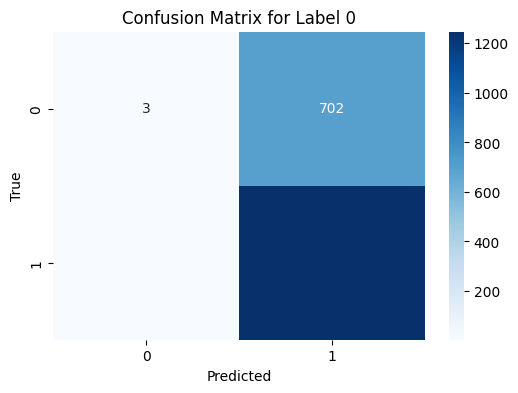

Confusion Matrix for Label 1:
[[  14 1732]
 [   1  208]]


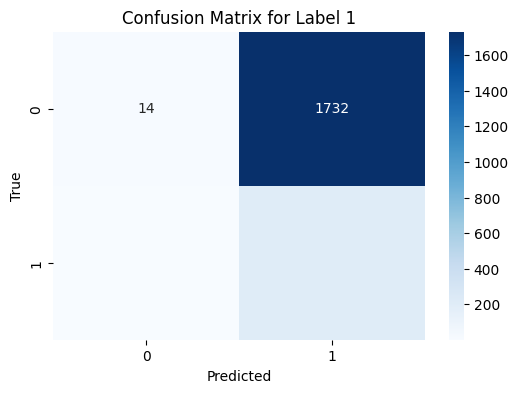

Confusion Matrix for Label 2:
[[   3 1078]
 [   1  873]]


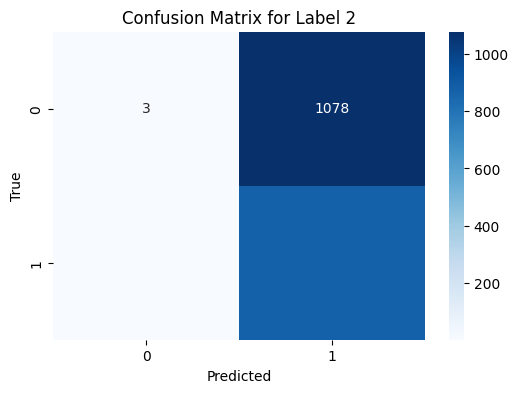

Confusion Matrix for Label 3:
[[1901    0]
 [  54    0]]


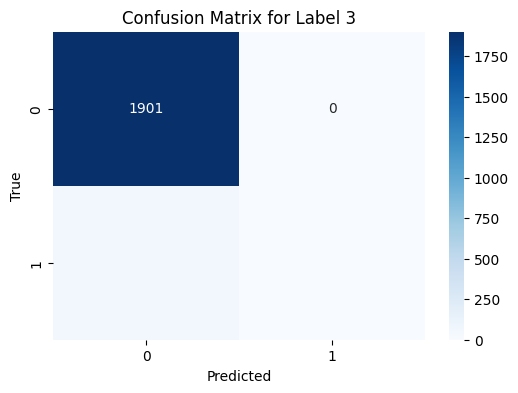

Confusion Matrix for Label 4:
[[  14 1099]
 [   4  838]]


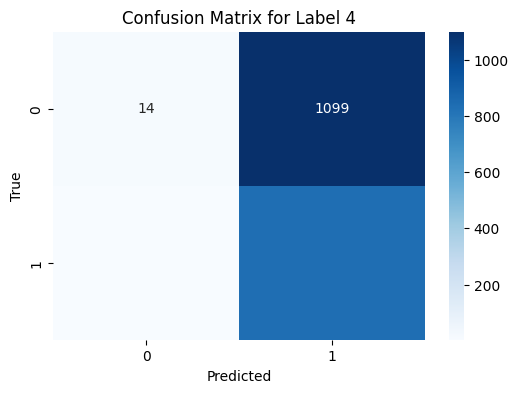

Confusion Matrix for Label 5:
[[  74 1721]
 [   4  156]]


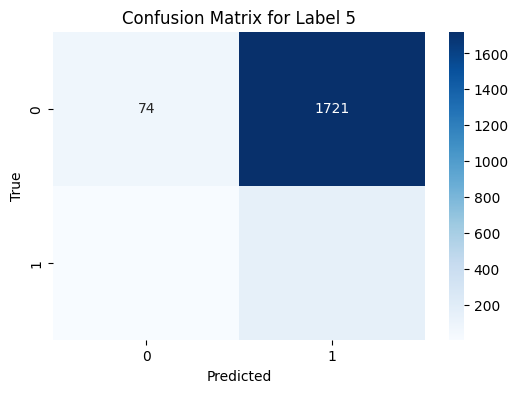

Classification Report:
              precision    recall  f1-score   support

     Label 0       0.64      1.00      0.78      1250
     Label 1       0.11      1.00      0.19       209
     Label 2       0.45      1.00      0.62       874
     Label 3       0.00      0.00      0.00        54
     Label 4       0.43      1.00      0.60       842
     Label 5       0.08      0.97      0.15       160

   micro avg       0.34      0.98      0.51      3389
   macro avg       0.29      0.83      0.39      3389
weighted avg       0.47      0.98      0.62      3389
 samples avg       0.34      0.65      0.43      3389



/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/.local/lib/python

In [47]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
best_params={'learning_rate': 0.0005492892514939486, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 192, 'class_weight_0': 1.773796522498064, 'class_weight_1': 10.972286617091951, 'class_weight_2': 4.667513607386336, 'class_weight_3': 0.10805032260723799, 'class_weight_4': 3.2623457048055413, 'class_weight_5': 11.630330627906481}
# Best validation loss: 0.6240191163658537
# best_params={'learning_rate': 2.2489721333468625e-05, 'batch_size': 56, 'hidden_dim': 768, 'embedding_dim': 576, 'class_weight_0': 6.721829636803498, 'class_weight_1': 4.395747145153693, 'class_weight_2': 0.6310783714793379, 'class_weight_3': 1.1934741441117767, 'class_weight_4': 0.16936453595688566, 'class_weight_5': 1.9489937195640668}
input_dim=tokenizer.vocab_size
embedding_dim = best_params['embedding_dim']
hidden_dim = best_params['hidden_dim']

output_dim = 6

model = RNN(input_dim, embedding_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('best_model_rnn.pth'))
model.to(device)

model.eval()  
all_preds = []
all_labels = []

with torch.no_grad():  
    for batch in test_loader:
        texts, text_lengths, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts, text_lengths)
        preds = torch.sigmoid(outputs)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
thresholded_preds = (all_preds > 0.5).astype(int)
for i in range(output_dim): 
    cm = confusion_matrix(all_labels[:, i], thresholded_preds[:, i])
    print(f"Confusion Matrix for Label {i}:")
    print(cm)

    # Optionally visualize the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f"Confusion Matrix for Label {i}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("Classification Report:")
print(classification_report(all_labels, thresholded_preds, target_names=[f"Label {i}" for i in range(output_dim)]))


In [48]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class RNNdotAttention(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)  
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 64) 
        self.fc3 = nn.Linear(64, output_dim)  

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)

        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        # Pass the packed sequence through the RNN  
        packed_output, _ = self.rnn(packed_embedded)
        # Unpack the output sequence
        output, _ = pad_packed_sequence(packed_output, batch_first=True)
        attn_weights = torch.softmax(self.attn(output), dim=1)  
        context_vector = torch.sum(attn_weights * output, dim=1)
        x = torch.relu(self.fc1(context_vector))
        x = torch.relu(self.fc2(x)) 
        return self.fc3(x) 


In [49]:
import optuna
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score,f1_score
import numpy as np

output_dim=6
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim=tokenizer.vocab_size


def objective(trial):
    # Define hyperparameters to search over
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 140, step=16)
    hidden_dim = trial.suggest_int('hidden_dim', 128, 768, step=128)
    embedding_dim = trial.suggest_int('embedding_dim', 128, 768, step=64)
    class_weights = [trial.suggest_float(f'class_weight_{i}', 0.1, 12, log=True) for i in range(output_dim)]
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=device)
    model = RNNdotAttention(input_dim, embedding_dim, hidden_dim, output_dim)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    best_val_loss = float('inf')
    
    num_epochs = 3 
    best_val_f1 = 0.0
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            texts, text_lengths, labels = batch
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts, text_lengths)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        val_true = []
        val_pred = []
        with torch.no_grad():
            for val_batch in val_loader:
                val_texts, val_text_lengths, val_labels = val_batch
                val_texts, val_labels = val_texts.to(device), val_labels.to(device)
                val_outputs = model(val_texts, val_text_lengths)
                val_loss += loss_fn(val_outputs, val_labels).item()
                val_preds = torch.sigmoid(val_outputs) > 0.5

                val_true.append(val_labels.cpu().numpy())
                val_pred.append(val_preds.cpu().numpy())
        
        val_loss /= len(val_loader)
        running_loss/=len(train_loader)
        val_true = np.concatenate(val_true, axis=0)
        val_pred = np.concatenate(val_pred, axis=0)

        val_f1 = f1_score(val_true, val_pred, average='weighted')
        print(f'Epoch {epoch+1}/{num_epochs}, Validation F1 Score: {val_f1:.4f}, Val Loss: {val_loss:.4f} Train Loss: {running_loss:.4f}')
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
    del model
    del optimizer, train_loader, val_loader, class_weights_tensor
    torch.cuda.empty_cache() 
    return best_val_f1

# Start the hyperparameter optimization with Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print("Best hyperparameters:", study.best_params)
print("Best validation loss:", study.best_value)


[I 2024-12-03 15:53:38,306] A new study created in memory with name: no-name-a6f8382e-6131-41f6-acb8-e2f5bd1b790d
/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6081, Val Loss: 0.5936 Train Loss: 0.6449


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7393, Val Loss: 0.4404 Train Loss: 0.5088


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:54:19,239] Trial 0 finished with value: 0.7392757872612293 and parameters: {'learning_rate': 0.00021594809421140272, 'batch_size': 40, 'hidden_dim': 768, 'embedding_dim': 192, 'class_weight_0': 1.9013676803418473, 'class_weight_1': 1.3114066043941446, 'class_weight_2': 1.8973402163362993, 'class_weight_3': 0.10272578858528071, 'class_weight_4': 2.368475897302791, 'class_weight_5': 2.110823264862868}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.7084, Val Loss: 0.4165 Train Loss: 0.4189


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.3879, Val Loss: 0.2498 Train Loss: 0.3603


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.5468, Val Loss: 0.2383 Train Loss: 0.2322


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:55:01,146] Trial 1 finished with value: 0.5468395998439033 and parameters: {'learning_rate': 0.0016650010266525655, 'batch_size': 88, 'hidden_dim': 640, 'embedding_dim': 256, 'class_weight_0': 0.10229683161318576, 'class_weight_1': 0.4966494761966497, 'class_weight_2': 2.7266676043738634, 'class_weight_3': 0.44893272296002407, 'class_weight_4': 0.1758094692213401, 'class_weight_5': 0.5947267222431235}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.4263, Val Loss: 0.2274 Train Loss: 0.2257


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.2865, Val Loss: 0.2844 Train Loss: 0.5176


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.2867, Val Loss: 0.2591 Train Loss: 0.2677


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:55:14,504] Trial 2 finished with value: 0.2866536189069424 and parameters: {'learning_rate': 0.00015352361200543797, 'batch_size': 88, 'hidden_dim': 128, 'embedding_dim': 384, 'class_weight_0': 1.6424931571928518, 'class_weight_1': 0.19074069396811075, 'class_weight_2': 0.22756548873921909, 'class_weight_3': 0.7369567049077166, 'class_weight_4': 0.12129348857161343, 'class_weight_5': 0.2827957363702021}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.2866, Val Loss: 0.2479 Train Loss: 0.2562


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4117, Val Loss: 0.3996 Train Loss: 0.5091


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4156, Val Loss: 0.3843 Train Loss: 0.3926


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:56:04,412] Trial 3 finished with value: 0.5737262105442987 and parameters: {'learning_rate': 4.834055062559887e-05, 'batch_size': 56, 'hidden_dim': 768, 'embedding_dim': 768, 'class_weight_0': 0.5774472957840897, 'class_weight_1': 0.5178349056618069, 'class_weight_2': 0.7228074178124229, 'class_weight_3': 0.28016709740404405, 'class_weight_4': 2.0851468615508306, 'class_weight_5': 0.2051181068825378}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.5737, Val Loss: 0.3618 Train Loss: 0.3787


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.0758, Val Loss: 0.4839 Train Loss: 0.5918


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.0430, Val Loss: 0.3973 Train Loss: 0.4330


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:56:25,103] Trial 4 finished with value: 0.07579698144413843 and parameters: {'learning_rate': 6.2362847258454e-05, 'batch_size': 104, 'hidden_dim': 256, 'embedding_dim': 384, 'class_weight_0': 0.17954658694886738, 'class_weight_1': 2.091735231824647, 'class_weight_2': 0.1615830674902721, 'class_weight_3': 9.074168870774592, 'class_weight_4': 0.6403467035159922, 'class_weight_5': 1.1793014512195983}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.0420, Val Loss: 0.3907 Train Loss: 0.4096


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4534, Val Loss: 0.5541 Train Loss: 0.9064


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.4538, Val Loss: 0.5259 Train Loss: 0.5376


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:56:43,500] Trial 5 finished with value: 0.4537662437652357 and parameters: {'learning_rate': 6.81089515110105e-05, 'batch_size': 72, 'hidden_dim': 256, 'embedding_dim': 256, 'class_weight_0': 5.051526171435025, 'class_weight_1': 0.5708875943192714, 'class_weight_2': 3.202244817797794, 'class_weight_3': 0.3896872783985213, 'class_weight_4': 0.2839506697963528, 'class_weight_5': 0.5987676670677521}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.4533, Val Loss: 0.5173 Train Loss: 0.5279


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6083, Val Loss: 1.0291 Train Loss: 1.1795


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6051, Val Loss: 0.7514 Train Loss: 0.8137


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:57:13,157] Trial 6 finished with value: 0.6083154543337412 and parameters: {'learning_rate': 1.1770303576787968e-05, 'batch_size': 40, 'hidden_dim': 512, 'embedding_dim': 512, 'class_weight_0': 2.5283775096029033, 'class_weight_1': 3.769454002112277, 'class_weight_2': 7.398594356508079, 'class_weight_3': 0.19712726651003923, 'class_weight_4': 1.7872914551575558, 'class_weight_5': 0.15004239209907289}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.6066, Val Loss: 0.7337 Train Loss: 0.7433


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6103, Val Loss: 0.9060 Train Loss: 0.9628


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6171, Val Loss: 0.8992 Train Loss: 0.9090


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:58:05,310] Trial 7 finished with value: 0.617137756156226 and parameters: {'learning_rate': 0.0003617114198699904, 'batch_size': 104, 'hidden_dim': 768, 'embedding_dim': 192, 'class_weight_0': 0.7278726625899639, 'class_weight_1': 10.125617184763891, 'class_weight_2': 3.5287169922853643, 'class_weight_3': 0.1921237174551365, 'class_weight_4': 7.9309626495928605, 'class_weight_5': 3.269056676123624}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.5411, Val Loss: 0.9510 Train Loss: 0.8852


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.3248, Val Loss: 0.4478 Train Loss: 0.6257


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.3367, Val Loss: 0.3980 Train Loss: 0.4119


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 15:59:06,988] Trial 8 finished with value: 0.3383598691549426 and parameters: {'learning_rate': 4.134783140605313e-05, 'batch_size': 136, 'hidden_dim': 768, 'embedding_dim': 704, 'class_weight_0': 1.377082148031698, 'class_weight_1': 0.3203810195614065, 'class_weight_2': 1.0730535537539032, 'class_weight_3': 2.124225475129318, 'class_weight_4': 0.13229012171072826, 'class_weight_5': 1.3309211595859518}. Best is trial 0 with value: 0.7392757872612293.


Epoch 3/3, Validation F1 Score: 0.3384, Val Loss: 0.3954 Train Loss: 0.4007


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7408, Val Loss: 0.6958 Train Loss: 0.9053


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7710, Val Loss: 0.6247 Train Loss: 0.6644


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:00:07,652] Trial 9 finished with value: 0.7847504210419849 and parameters: {'learning_rate': 0.00011074152078453726, 'batch_size': 8, 'hidden_dim': 128, 'embedding_dim': 704, 'class_weight_0': 1.599438650618516, 'class_weight_1': 10.638551159504384, 'class_weight_2': 0.9036579091823564, 'class_weight_3': 11.896552981024412, 'class_weight_4': 5.181675581794745, 'class_weight_5': 8.830957595634914}. Best is trial 9 with value: 0.7847504210419849.


Epoch 3/3, Validation F1 Score: 0.7848, Val Loss: 0.5946 Train Loss: 0.5905


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7478, Val Loss: 0.7638 Train Loss: 0.8983


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7612, Val Loss: 0.6852 Train Loss: 0.6957


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:01:01,659] Trial 10 finished with value: 0.7612299532233122 and parameters: {'learning_rate': 0.005422659710590891, 'batch_size': 8, 'hidden_dim': 128, 'embedding_dim': 576, 'class_weight_0': 11.600469822601978, 'class_weight_1': 11.670372617252921, 'class_weight_2': 0.4398385819103956, 'class_weight_3': 10.960122411469044, 'class_weight_4': 9.934651340093373, 'class_weight_5': 11.785694600572555}. Best is trial 9 with value: 0.7847504210419849.


Epoch 3/3, Validation F1 Score: 0.7456, Val Loss: 0.6987 Train Loss: 0.6039


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6930, Val Loss: 0.8253 Train Loss: 0.9184


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7458, Val Loss: 0.8141 Train Loss: 0.8069


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:01:55,690] Trial 11 finished with value: 0.7458343580311873 and parameters: {'learning_rate': 0.008901169464561105, 'batch_size': 8, 'hidden_dim': 128, 'embedding_dim': 576, 'class_weight_0': 10.960289658822061, 'class_weight_1': 10.84756497367664, 'class_weight_2': 0.39629155661671445, 'class_weight_3': 10.238658256697041, 'class_weight_4': 9.852246807299647, 'class_weight_5': 10.99420495607299}. Best is trial 9 with value: 0.7847504210419849.


Epoch 3/3, Validation F1 Score: 0.7282, Val Loss: 0.7849 Train Loss: 0.7283


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7559, Val Loss: 0.6206 Train Loss: 0.7464


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7857, Val Loss: 0.5216 Train Loss: 0.5521


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:02:52,133] Trial 12 finished with value: 0.7880658474567197 and parameters: {'learning_rate': 0.0010108886220207538, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 10.58840256491662, 'class_weight_1': 4.829367116262253, 'class_weight_2': 0.5485925823976235, 'class_weight_3': 3.625672510869755, 'class_weight_4': 4.9276979222759, 'class_weight_5': 11.639659133168506}. Best is trial 12 with value: 0.7880658474567197.


Epoch 3/3, Validation F1 Score: 0.7881, Val Loss: 0.5344 Train Loss: 0.4406


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7120, Val Loss: 0.4996 Train Loss: 0.6221


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7744, Val Loss: 0.4400 Train Loss: 0.4453


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:03:23,884] Trial 13 finished with value: 0.7744225438072392 and parameters: {'learning_rate': 0.0008364239442493918, 'batch_size': 24, 'hidden_dim': 384, 'embedding_dim': 704, 'class_weight_0': 4.428493291731166, 'class_weight_1': 3.973760638294116, 'class_weight_2': 0.10765115819943778, 'class_weight_3': 3.451680310759453, 'class_weight_4': 4.410380756935979, 'class_weight_5': 5.6606150024463044}. Best is trial 12 with value: 0.7880658474567197.


Epoch 3/3, Validation F1 Score: 0.7378, Val Loss: 0.4072 Train Loss: 0.3607


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7689, Val Loss: 0.4554 Train Loss: 0.5460


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.8045, Val Loss: 0.3989 Train Loss: 0.4099


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:04:21,274] Trial 14 finished with value: 0.8151966503257426 and parameters: {'learning_rate': 0.0017428592083351367, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.5327873196096997, 'class_weight_1': 4.740002843441082, 'class_weight_2': 0.6584036538178126, 'class_weight_3': 4.1796731982231625, 'class_weight_4': 4.078927358433973, 'class_weight_5': 4.632167063897202}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.8152, Val Loss: 0.3920 Train Loss: 0.3319


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7148, Val Loss: 0.3753 Train Loss: 0.4741


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7867, Val Loss: 0.3371 Train Loss: 0.3581


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:04:47,341] Trial 15 finished with value: 0.8084540698087942 and parameters: {'learning_rate': 0.002234498354812423, 'batch_size': 40, 'hidden_dim': 384, 'embedding_dim': 576, 'class_weight_0': 0.3638654328308294, 'class_weight_1': 4.239684465430517, 'class_weight_2': 0.4014194784870524, 'class_weight_3': 3.570266333013994, 'class_weight_4': 0.8152640858755131, 'class_weight_5': 4.4180970586428705}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.8085, Val Loss: 0.3089 Train Loss: 0.3023


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7186, Val Loss: 0.3389 Train Loss: 0.4111


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6652, Val Loss: 0.3337 Train Loss: 0.3374


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:05:11,957] Trial 16 finished with value: 0.7185958145955789 and parameters: {'learning_rate': 0.0025586665758493485, 'batch_size': 40, 'hidden_dim': 384, 'embedding_dim': 448, 'class_weight_0': 0.33581334189148243, 'class_weight_1': 2.069833779069734, 'class_weight_2': 0.3057487743059894, 'class_weight_3': 1.596528511797766, 'class_weight_4': 0.7704082532778073, 'class_weight_5': 3.8718205096665983}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.6906, Val Loss: 0.3169 Train Loss: 0.3151


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.4264, Val Loss: 0.5461 Train Loss: 0.5724


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.5072, Val Loss: 0.5185 Train Loss: 0.5423


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:05:44,558] Trial 17 finished with value: 0.607352615435657 and parameters: {'learning_rate': 0.0038120158025941606, 'batch_size': 24, 'hidden_dim': 512, 'embedding_dim': 576, 'class_weight_0': 0.3798046892237085, 'class_weight_1': 5.4685680416983455, 'class_weight_2': 1.2525051774254667, 'class_weight_3': 4.525737692361039, 'class_weight_4': 0.46697937392572386, 'class_weight_5': 2.307739008820455}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.6074, Val Loss: 0.4310 Train Loss: 0.4902


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6045, Val Loss: 0.4116 Train Loss: 0.5170


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7132, Val Loss: 0.3645 Train Loss: 0.3858


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:06:09,610] Trial 18 finished with value: 0.7384690417138037 and parameters: {'learning_rate': 0.000563560859816723, 'batch_size': 56, 'hidden_dim': 384, 'embedding_dim': 448, 'class_weight_0': 0.25292228464742994, 'class_weight_1': 2.4940215893775366, 'class_weight_2': 0.19543125612148346, 'class_weight_3': 5.472696793966193, 'class_weight_4': 1.2030909351221464, 'class_weight_5': 5.499703310598521}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.7385, Val Loss: 0.3302 Train Loss: 0.3434


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6677, Val Loss: 0.5362 Train Loss: 0.6604


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7232, Val Loss: 0.5294 Train Loss: 0.5236


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:06:45,571] Trial 19 finished with value: 0.7590152124863536 and parameters: {'learning_rate': 0.0014074521424719568, 'batch_size': 24, 'hidden_dim': 512, 'embedding_dim': 768, 'class_weight_0': 0.7750119827459674, 'class_weight_1': 1.0480044676243048, 'class_weight_2': 8.965471827826274, 'class_weight_3': 1.7987191276530206, 'class_weight_4': 1.0837967984705388, 'class_weight_5': 5.8968541752090395}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.7590, Val Loss: 0.4630 Train Loss: 0.4532


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6374, Val Loss: 0.2706 Train Loss: 0.3302


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.6689, Val Loss: 0.2618 Train Loss: 0.2552


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:07:07,326] Trial 20 finished with value: 0.7280991546322626 and parameters: {'learning_rate': 0.009974319391899734, 'batch_size': 56, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.11654262206899128, 'class_weight_1': 1.339526397906608, 'class_weight_2': 1.641537793093864, 'class_weight_3': 0.9788680022246787, 'class_weight_4': 0.3041048948096121, 'class_weight_5': 2.0268027351514943}. Best is trial 14 with value: 0.8151966503257426.


Epoch 3/3, Validation F1 Score: 0.7281, Val Loss: 0.2449 Train Loss: 0.2272


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7641, Val Loss: 0.4951 Train Loss: 0.5538


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7936, Val Loss: 0.4259 Train Loss: 0.4299


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:08:03,177] Trial 21 finished with value: 0.8179142034033379 and parameters: {'learning_rate': 0.0010989659687987467, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.5046861530266205, 'class_weight_1': 5.795947830648565, 'class_weight_2': 0.629405298482583, 'class_weight_3': 2.9607408081927087, 'class_weight_4': 4.46619480825811, 'class_weight_5': 7.720918516922236}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.8179, Val Loss: 0.4042 Train Loss: 0.3529


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7567, Val Loss: 0.4404 Train Loss: 0.5311


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7664, Val Loss: 0.4174 Train Loss: 0.4322


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:08:31,233] Trial 22 finished with value: 0.7847639605217062 and parameters: {'learning_rate': 0.0023218939272565253, 'batch_size': 24, 'hidden_dim': 384, 'embedding_dim': 512, 'class_weight_0': 0.4736399376533412, 'class_weight_1': 6.0390422869137605, 'class_weight_2': 0.7187878930575294, 'class_weight_3': 2.9947338332704447, 'class_weight_4': 3.0828855652658826, 'class_weight_5': 3.789178560453327}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7848, Val Loss: 0.4180 Train Loss: 0.3885


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7403, Val Loss: 0.4358 Train Loss: 0.5639


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7656, Val Loss: 0.3808 Train Loss: 0.4110


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:08:54,040] Trial 23 finished with value: 0.7906784936094964 and parameters: {'learning_rate': 0.0005278655932573158, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.28021484931067675, 'class_weight_1': 2.7553055253623175, 'class_weight_2': 0.3164233059041373, 'class_weight_3': 6.993094541042025, 'class_weight_4': 3.1219380132617354, 'class_weight_5': 6.025820623557236}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7907, Val Loss: 0.3558 Train Loss: 0.3388


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7342, Val Loss: 0.4180 Train Loss: 0.5192


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7366, Val Loss: 0.4889 Train Loss: 0.4186


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:09:22,589] Trial 24 finished with value: 0.76464692070147 and parameters: {'learning_rate': 0.004242859619413103, 'batch_size': 24, 'hidden_dim': 384, 'embedding_dim': 512, 'class_weight_0': 0.9382164760441933, 'class_weight_1': 6.531294310190587, 'class_weight_2': 0.5310530485763367, 'class_weight_3': 2.4940522464961496, 'class_weight_4': 1.2876526165803175, 'class_weight_5': 2.8464682188169284}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7646, Val Loss: 0.4043 Train Loss: 0.3935


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7687, Val Loss: 0.4503 Train Loss: 0.5262


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7872, Val Loss: 0.3950 Train Loss: 0.3889


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:10:18,596] Trial 25 finished with value: 0.7871706829456668 and parameters: {'learning_rate': 0.0010079142153046406, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.18109104676608478, 'class_weight_1': 7.519851328270762, 'class_weight_2': 0.6983470987369709, 'class_weight_3': 1.4625930951005222, 'class_weight_4': 3.3039934950501997, 'class_weight_5': 7.008816541221854}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7485, Val Loss: 0.3787 Train Loss: 0.3202


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.5621, Val Loss: 0.5602 Train Loss: 0.5986


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.5792, Val Loss: 0.4731 Train Loss: 0.5039


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:11:02,021] Trial 26 finished with value: 0.6325697570244874 and parameters: {'learning_rate': 0.0023179588013491083, 'batch_size': 24, 'hidden_dim': 640, 'embedding_dim': 576, 'class_weight_0': 0.5209573600473821, 'class_weight_1': 3.55402011355983, 'class_weight_2': 0.28603577512208017, 'class_weight_3': 5.781719414718049, 'class_weight_4': 6.381979938388838, 'class_weight_5': 0.659208503320123}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.6326, Val Loss: 0.4774 Train Loss: 0.4671


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7491, Val Loss: 0.2850 Train Loss: 0.3709


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7228, Val Loss: 0.2444 Train Loss: 0.2622


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:11:25,464] Trial 27 finished with value: 0.7491095123426064 and parameters: {'learning_rate': 0.0005387338069238383, 'batch_size': 40, 'hidden_dim': 256, 'embedding_dim': 704, 'class_weight_0': 0.20770623788154025, 'class_weight_1': 0.8488243234235532, 'class_weight_2': 0.13110596132735208, 'class_weight_3': 0.9445688187190845, 'class_weight_4': 1.650293388714291, 'class_weight_5': 4.352342954467697}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7490, Val Loss: 0.2244 Train Loss: 0.2158


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.7768, Val Loss: 0.4793 Train Loss: 0.5602


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7611, Val Loss: 0.4551 Train Loss: 0.4659


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:12:15,010] Trial 28 finished with value: 0.7908664693548584 and parameters: {'learning_rate': 0.0014985879120632249, 'batch_size': 8, 'hidden_dim': 384, 'embedding_dim': 384, 'class_weight_0': 0.9621752851932787, 'class_weight_1': 1.7839310383391171, 'class_weight_2': 1.5118570336935653, 'class_weight_3': 4.181974071636161, 'class_weight_4': 0.8468203731163296, 'class_weight_5': 8.213759632390904}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7909, Val Loss: 0.4137 Train Loss: 0.4011


/home/danial/.local/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning: The distribution is specified by [8, 140] and step=16, but the range is not divisible by `step`. It will be replaced by [8, 136].
  warnings.warn(
/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/3, Validation F1 Score: 0.6658, Val Loss: 0.4533 Train Loss: 0.6312


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/3, Validation F1 Score: 0.7678, Val Loss: 0.3572 Train Loss: 0.3856


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)
[I 2024-12-03 16:12:35,270] Trial 29 finished with value: 0.7769953842477025 and parameters: {'learning_rate': 0.0002882140393882726, 'batch_size': 40, 'hidden_dim': 128, 'embedding_dim': 768, 'class_weight_0': 0.4116288195832988, 'class_weight_1': 7.65353452129922, 'class_weight_2': 2.521946904151063, 'class_weight_3': 2.5273641732337344, 'class_weight_4': 0.4984626218149177, 'class_weight_5': 1.8910979322292638}. Best is trial 21 with value: 0.8179142034033379.


Epoch 3/3, Validation F1 Score: 0.7770, Val Loss: 0.3534 Train Loss: 0.3253
Best hyperparameters: {'learning_rate': 0.0010989659687987467, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.5046861530266205, 'class_weight_1': 5.795947830648565, 'class_weight_2': 0.629405298482583, 'class_weight_3': 2.9607408081927087, 'class_weight_4': 4.46619480825811, 'class_weight_5': 7.720918516922236}
Best validation loss: 0.8179142034033379


In [50]:
# best_params={'learning_rate': 0.0007184241317083276, 'batch_size': 8, 'hidden_dim': 512, 'embedding_dim': 768, 'class_weight_0': 0.8004835837210632, 'class_weight_1': 4.534872323362911, 'class_weight_2': 0.2256822407613201, 'class_weight_3': 0.23984828002230094, 'class_weight_4': 0.5752762579116124, 'class_weight_5': 3.843123075535228}
best_params={'learning_rate': 0.0010989659687987467, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.5046861530266205, 'class_weight_1': 5.795947830648565, 'class_weight_2': 0.629405298482583, 'class_weight_3': 2.9607408081927087, 'class_weight_4': 4.46619480825811, 'class_weight_5': 7.720918516922236}
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score
input_dim=tokenizer.vocab_size
embedding_dim = best_params['embedding_dim']
hidden_dim = best_params['hidden_dim']
output_dim = 6
model = RNNdotAttention(input_dim, embedding_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
class_weights = [
    best_params['class_weight_0'], 
    best_params['class_weight_1'], 
    best_params['class_weight_2'], 
    best_params['class_weight_3'], 
    best_params['class_weight_4'], 
    best_params['class_weight_5']
]

pos_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights_tensor)  # For multi-label classification
optimizer = optim.Adam(model.parameters(), lr=best_params['learning_rate'])


best_val_loss = float('inf') 

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=best_params['batch_size'], shuffle=False, collate_fn=collate_fn)

best_val_f1=0.0
num_epochs = 35
for epoch in range(num_epochs):
    model.train() 
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for batch in train_loader:
        texts, text_lengths, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(texts, text_lengths)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}')
    model.eval()  
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for val_batch in val_loader:
            val_texts, val_text_lengths, val_labels = val_batch
            val_texts, val_labels = val_texts.to(device), val_labels.to(device)

            val_outputs = model(val_texts, val_text_lengths)
            val_loss += loss_fn(val_outputs, val_labels).item()

            val_preds = torch.sigmoid(val_outputs)  # Apply sigmoid
            all_val_preds.append(val_preds.cpu().numpy())
            all_val_labels.append(val_labels.cpu().numpy())


    val_loss /= len(val_loader)
    all_val_preds = np.concatenate(all_val_preds, axis=0)
    all_val_labels = np.concatenate(all_val_labels, axis=0)
    thresholded_preds = (all_val_preds > 0.5).astype(int)
    val_f1 = f1_score(all_val_labels, thresholded_preds, average='weighted')


    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation f1: {val_f1:.4f}')
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_model_diff_attention.pth')
        print(f"Best model saved at epoch {epoch+1} with validation loss: {best_val_f1:.4f}") 
model.load_state_dict(torch.load('best_model_diff_attention.pth'))
print("Best model loaded.")


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 1/35, Training Loss: 0.5799
Epoch 1/35, Validation Loss: 0.4724, Validation f1: 0.7860
Best model saved at epoch 1 with validation loss: 0.7860


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 2/35, Training Loss: 0.4344
Epoch 2/35, Validation Loss: 0.4387, Validation f1: 0.7685


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 3/35, Training Loss: 0.3597
Epoch 3/35, Validation Loss: 0.4026, Validation f1: 0.8078
Best model saved at epoch 3 with validation loss: 0.8078


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 4/35, Training Loss: 0.3014
Epoch 4/35, Validation Loss: 0.4439, Validation f1: 0.8238
Best model saved at epoch 4 with validation loss: 0.8238


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 5/35, Training Loss: 0.2557
Epoch 5/35, Validation Loss: 0.4711, Validation f1: 0.8302
Best model saved at epoch 5 with validation loss: 0.8302


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 6/35, Training Loss: 0.2171
Epoch 6/35, Validation Loss: 0.4917, Validation f1: 0.8202


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 7/35, Training Loss: 0.1877
Epoch 7/35, Validation Loss: 0.5291, Validation f1: 0.8241


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 8/35, Training Loss: 0.1610
Epoch 8/35, Validation Loss: 0.5175, Validation f1: 0.8382
Best model saved at epoch 8 with validation loss: 0.8382


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 9/35, Training Loss: 0.1459
Epoch 9/35, Validation Loss: 0.6224, Validation f1: 0.8335


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 10/35, Training Loss: 0.1271
Epoch 10/35, Validation Loss: 0.5958, Validation f1: 0.8314


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 11/35, Training Loss: 0.1110
Epoch 11/35, Validation Loss: 0.6360, Validation f1: 0.8197


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 12/35, Training Loss: 0.1008
Epoch 12/35, Validation Loss: 0.8334, Validation f1: 0.8351


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 13/35, Training Loss: 0.0997
Epoch 13/35, Validation Loss: 0.6952, Validation f1: 0.8289


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 14/35, Training Loss: 0.0915
Epoch 14/35, Validation Loss: 0.7281, Validation f1: 0.8305


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 15/35, Training Loss: 0.0774
Epoch 15/35, Validation Loss: 0.9214, Validation f1: 0.8384
Best model saved at epoch 15 with validation loss: 0.8384


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 16/35, Training Loss: 0.0668
Epoch 16/35, Validation Loss: 1.1056, Validation f1: 0.8319


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 17/35, Training Loss: 0.0713
Epoch 17/35, Validation Loss: 0.8887, Validation f1: 0.8235


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 18/35, Training Loss: 0.0674
Epoch 18/35, Validation Loss: 0.8361, Validation f1: 0.8361


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 19/35, Training Loss: 0.0658
Epoch 19/35, Validation Loss: 0.8751, Validation f1: 0.8273


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 20/35, Training Loss: 0.0610
Epoch 20/35, Validation Loss: 0.8107, Validation f1: 0.8355


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 21/35, Training Loss: 0.0523
Epoch 21/35, Validation Loss: 0.9699, Validation f1: 0.8298


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 22/35, Training Loss: 0.0504
Epoch 22/35, Validation Loss: 1.1598, Validation f1: 0.8267


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 23/35, Training Loss: 0.0505
Epoch 23/35, Validation Loss: 1.0146, Validation f1: 0.8319


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 24/35, Training Loss: 0.0474
Epoch 24/35, Validation Loss: 1.0316, Validation f1: 0.8295


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 25/35, Training Loss: 0.0465
Epoch 25/35, Validation Loss: 1.0307, Validation f1: 0.8279


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 26/35, Training Loss: 0.0516
Epoch 26/35, Validation Loss: 1.1770, Validation f1: 0.8308


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 27/35, Training Loss: 0.0463
Epoch 27/35, Validation Loss: 0.9982, Validation f1: 0.8277


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 28/35, Training Loss: 0.0451
Epoch 28/35, Validation Loss: 0.9881, Validation f1: 0.8263


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 29/35, Training Loss: 0.0361
Epoch 29/35, Validation Loss: 1.0462, Validation f1: 0.8346


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 30/35, Training Loss: 0.0422
Epoch 30/35, Validation Loss: 1.0439, Validation f1: 0.8326


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 31/35, Training Loss: 0.0416
Epoch 31/35, Validation Loss: 1.1520, Validation f1: 0.8261


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 32/35, Training Loss: 0.0314
Epoch 32/35, Validation Loss: 1.2786, Validation f1: 0.8235


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 33/35, Training Loss: 0.0365
Epoch 33/35, Validation Loss: 1.1828, Validation f1: 0.8259


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 34/35, Training Loss: 0.0359
Epoch 34/35, Validation Loss: 1.2015, Validation f1: 0.8211


/tmp/ipykernel_29562/1861188038.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_texts = pad_sequence([torch.tensor(text) for text in texts], batch_first=True, padding_value=0)


Epoch 35/35, Training Loss: 0.0344
Epoch 35/35, Validation Loss: 1.4099, Validation f1: 0.8346
Best model loaded.


/tmp/ipykernel_29562/2229153741.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_diff_attention.pth'))


/tmp/ipykernel_29562/2211951026.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_diff_attention.pth'))
/tmp/ipykernel_29562/

Confusion Matrix for Label 0:
[[ 468  237]
 [  69 1181]]


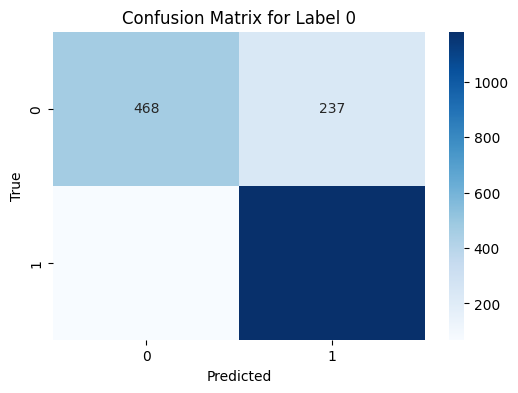

Confusion Matrix for Label 1:
[[1600  146]
 [  54  155]]


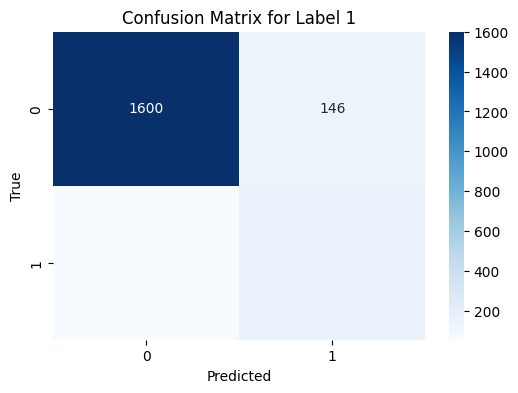

Confusion Matrix for Label 2:
[[939 142]
 [110 764]]


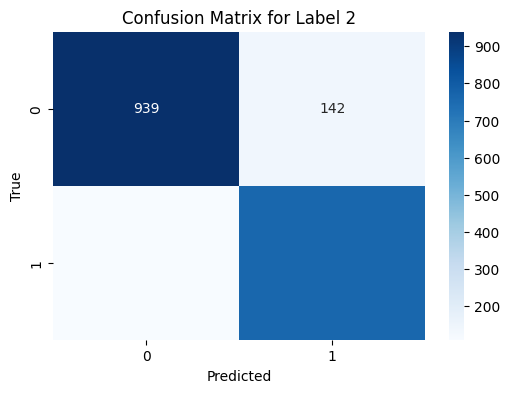

Confusion Matrix for Label 3:
[[1867   34]
 [  17   37]]


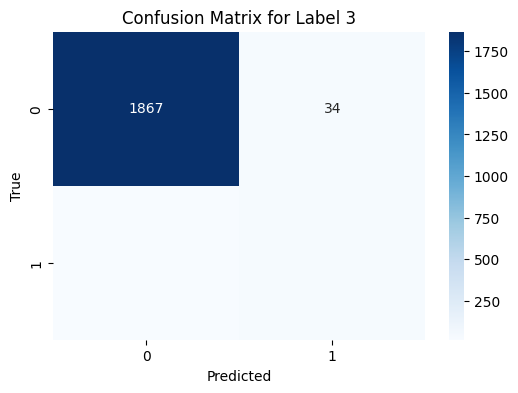

Confusion Matrix for Label 4:
[[887 226]
 [ 97 745]]


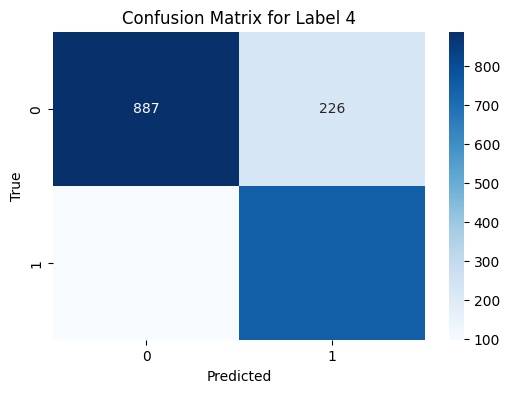

Confusion Matrix for Label 5:
[[1729   66]
 [  54  106]]


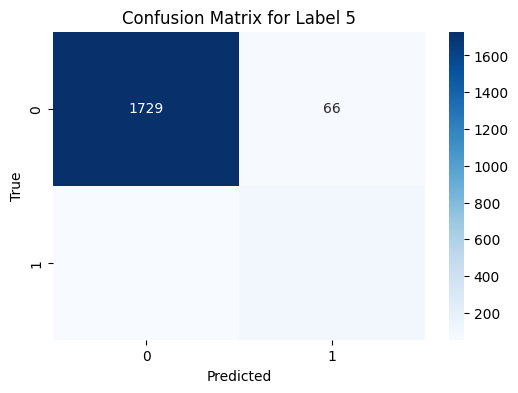

Classification Report:
              precision    recall  f1-score   support

     Label 0       0.83      0.94      0.89      1250
     Label 1       0.51      0.74      0.61       209
     Label 2       0.84      0.87      0.86       874
     Label 3       0.52      0.69      0.59        54
     Label 4       0.77      0.88      0.82       842
     Label 5       0.62      0.66      0.64       160

   micro avg       0.78      0.88      0.83      3389
   macro avg       0.68      0.80      0.73      3389
weighted avg       0.78      0.88      0.83      3389
 samples avg       0.54      0.57      0.54      3389



/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/danial/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [51]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
best_params={'learning_rate': 0.0010989659687987467, 'batch_size': 8, 'hidden_dim': 256, 'embedding_dim': 640, 'class_weight_0': 0.5046861530266205, 'class_weight_1': 5.795947830648565, 'class_weight_2': 0.629405298482583, 'class_weight_3': 2.9607408081927087, 'class_weight_4': 4.46619480825811, 'class_weight_5': 7.720918516922236}

# best_params={'learning_rate': 0.0007184241317083276, 'batch_size': 8, 'hidden_dim': 512, 'embedding_dim': 768, 'class_weight_0': 0.8004835837210632, 'class_weight_1': 4.534872323362911, 'class_weight_2': 0.2256822407613201, 'class_weight_3': 0.23984828002230094, 'class_weight_4': 0.5752762579116124, 'class_weight_5': 3.843123075535228}

input_dim=tokenizer.vocab_size
embedding_dim = best_params['embedding_dim']
hidden_dim = best_params['hidden_dim']

output_dim = 6

model = RNNdotAttention(input_dim, embedding_dim, hidden_dim, output_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('best_model_diff_attention.pth'))
model.to(device)

model.eval()  
all_preds = []
all_labels = []

with torch.no_grad():  
    for batch in test_loader:
        texts, text_lengths, labels = batch
        texts, labels = texts.to(device), labels.to(device)
        outputs = model(texts, text_lengths)
        preds = torch.sigmoid(outputs)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)
thresholded_preds = (all_preds > 0.5).astype(int)
for i in range(output_dim): 
    cm = confusion_matrix(all_labels[:, i], thresholded_preds[:, i])
    print(f"Confusion Matrix for Label {i}:")
    print(cm)

    # Optionally visualize the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    plt.title(f"Confusion Matrix for Label {i}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

print("Classification Report:")
print(classification_report(all_labels, thresholded_preds, target_names=[f"Label {i}" for i in range(output_dim)]))
